In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
plt.rcParams["figure.figsize"] = (25,10)

plt.rcParams.update({'font.size': 22})

In [2]:
class WF_class():
    def __init__(self, Ea,Eb,y_N, y_N_1, r_N, h, l, Z):
        self.Ea= Ea
        self.Eb= Eb
        self.y_N= y_N
        self.y_N_1= y_N_1
        self.r_N= r_N
        self.h=h
        self.l=l
        self.Z=Z
        self.E=None
        self.U_normalized=False
        self.U=None
        self.wf=None #normalized wave function
            
    def set_u_function_array(self,U_function_array):
        self.U= U_function_array
        
    def set_r_grid(self, r_grid):
        self.r_grid= r_grid
        
    def check_if_eigenvalue(self):
        if abs(self.Ea - self.Eb) > 1e-9:
            return False
        else:
            self.E= (self.Ea + self.Eb)/2.0
            return True
        
    def bild_normalized_wf(self):
        temp= np.squeeze(np.array(self.U))**2.0
        I=np.sum((self.h/2.0)*(temp[1:]+temp[:-1]))
        I=I**0.5
        self.wf=(1.0/I)*(np.squeeze(np.array(self.U))/np.squeeze(np.array(self.r_grid)))
        self.U_normalized=True
        self.U= (1.0/I)*np.squeeze(np.array(self.U))
    
    def save_as_json(self, path):
        temp={'Ea':self.Ea, 
                'Eb':self.Eb,
                'y_N':self.y_N, 
                'y_N_1':self.y_N_1,
                'r_N':self.r_N,
                'h':self.h,
                'l':self.l,
                'Z':self.Z,
                'E':self.E,
                'U_normalized':self.U_normalized,
                'r_grid':list(self.r_grid),
                'U':list(self.U),
                'wf':list(self.wf)}
        json.dump(temp, open(path, 'w'))
    
    def restore_from_json(self, path):
        temp= json.load(open(path, 'r'))
        self.Ea= temp['Ea']
        self.Eb= temp['Eb']
        self.y_N= temp['y_N']
        self.y_N_1= temp['y_N_1']
        self.r_N= temp['r_N']
        self.h=temp['h']
        self.l=temp['l']
        self.Z=temp['Z']
        self.E=temp['E']
        self.U_normalized=temp['U_normalized']
        self.r_grid=np.array(temp['r_grid'])
        self.U=np.array(temp['U'])
        self.wf=np.array(temp['wf'])
        

In [3]:
def V_ext(r_n, Z):
    return (-1.0*Z)/r_n

def V_angular(r_n,l):
    return (l*(l+1))/(2.0*(r_n**2.0))

#def V_potential(r_n,Z,l):
#    return V_ext(r_n, Z) - V_angular(r_n,l)

def K2(E,r_n, l, Z):#specific to schrodinger equation's
    return 2.0*(E - V_ext(r_n, Z) - V_angular(r_n,l))

The Numerov algorithm:

$ \frac{\Delta x^2}{12} \Big[ s_{n+1} + 10s_{n} + s_{n-1} \Big] = \Big(1 + \frac{\Delta x^2 k^2_{n+1}}{12} \Big)y_{n+1} -2 \Big(1 - \frac{5 \Delta x^2 k^2_{n}}{12} \Big)y_{n} + \Big(1 + \frac{\Delta x^2 k^2_{n-1}}{12} \Big)y_{n-1} + O(\Delta x^6)$

for Schrodinger equation the $s_n = 0$ for all $n$ then the Numerov alforithm

$ 0 = \Big(1 + \frac{\Delta x^2 k^2_{n+1}}{12} \Big)y_{n+1} -2 \Big(1 - \frac{5 \Delta x^2 k^2_{n}}{12} \Big)y_{n} + \Big(1 + \frac{\Delta x^2 k^2_{n-1}}{12} \Big)y_{n-1} + O(\Delta x^6)$

Usign
$G(\Delta x, k^2_{n}, \gamma) = \Big(1 + \frac{\gamma \Delta x^2 k^2_{n}}{12} \Big)$

Then Numerov

$ 0 = G(\Delta x, k^2_{n+1}, 1.0)y_{n+1} -2 G(\Delta x, k^2_{n}, -5.0) y_{n} + G(\Delta x, k^2_{n-1}, 1.0)y_{n-1} + O(\Delta x^6)$



Making the $n+1 => n$ making 

Then Numerov

$ 0 = G(\Delta x, k^2_{n}, 1.0)y_{n} -2 G(\Delta x, k^2_{n-1}, -5.0) y_{n-1} + G(\Delta x, k^2_{n-2}, 1.0)y_{n-2} + O(\Delta x^6)$

Arraiging the elements to find $y_{n-2}$

$\frac{2 G(\Delta x, k^2_{n-1}, -5.0) y_{n-1} - G(\Delta x, k^2_{n}, 1.0)y_{n}} {G(\Delta x, k^2_{n-2}, 1.0)} = y_{n-2} $

In [4]:
def G(h,K2, gamma=1.0):
    temp= (1.0 + (gamma*(h**2.0)*K2)/12.0)
    return temp
def Numerov_backwards(y_N, y_N_1, r_N, E, h, l, Z):
    #integrates a function starting at R_N
    #finishing at r_0 != 0.0
    #
    r_n_2= r_N - 2.0*h
    y_func=[y_N, y_N_1]#wave function array
    r_grid=[r_N, r_N-h]
    n=0
    while r_n_2>0.0:
        K2n= K2(E,r_grid[n], l, Z)
        K2n_1= K2(E,r_grid[n+1], l, Z)
        K2n_2= K2(E,r_n_2, l, Z)
        y_n_2= (2.0*G(h,K2n_1, gamma=-5.0)*y_func[n+1] - G(h,K2n)*y_func[n])/(G(h,K2n_2))
        r_grid.append(r_n_2)
        y_func.append(y_n_2)
        n+=1
        r_n_2-=h
    return np.flip(np.array(y_func)), np.flip(np.array(r_grid))

In [5]:
def get_nodes_information(f, x):
    #input: f -> an f(x) array with the functions values
    #input: x -> array with the x values
    #output: number of nodes in f (wave function)
    #and the (x1, x2)_i values in between the i node is
    #x1 < x2
    number_of_nodes=0
    nodes_positions=[]
    for i, _ in enumerate(f[:-1]):
        if int(np.sign(f[i])) != int(np.sign(f[i+1])):
            number_of_nodes+=1
            if x[i] < x[i+1]:
                nodes_positions.append((x[i], x[i+1]))
            else:
                nodes_positions.append((x[i+1], x[i]))
    return number_of_nodes, nodes_positions

In [6]:
h=0.001#delta_r
#l=0 #angular momentum number
Z=1.0# number of protons in atom
r_N_arra=[18.0, 21.0] #max radius of integration
l_arra= [0, 1]
y_N= 1.8e-8#U(r_N)
y_N_1= 2.0e-8#0.0000001#U((r_N-h))


In [7]:
E_arra= list(np.arange(-0.80, -0.01, 0.12))+ list(np.arange(-0.09, -0.009, 0.012)) + list(np.arange(-0.009, -0.0009, 0.0012))

In [8]:
potential_eigen_func=[]
for l in l_arra:
    for r_N in r_N_arra:
        U0=[]
        for E_i in E_arra:
            wf, r_grid= Numerov_backwards(y_N, y_N_1, r_N, E_i, h,  l, Z)
            U0.append(wf[0])
        number_of_nodes, nodes_positions= get_nodes_information(U0, E_arra)
        if number_of_nodes > 0:
            for elem in nodes_positions:
                potential_eigen_func.append(Radial_Eigenfunction(elem[0],elem[1],y_N, y_N_1, r_N, h, l,Z))

In [9]:
def false_position(Ea,Eb,fa,fb):
    #for root finding algorithm
    return (Eb*fa - Ea*fb)/(fa - fb)

In [10]:
for i in range(len(potential_eigen_func)):
    print(potential_eigen_func[i].Ea)
    print(potential_eigen_func[i].Eb)
    print('________________________')

-0.56
-0.44000000000000006
________________________
-0.20000000000000007
-0.08000000000000007
________________________
-0.054000000000000006
-0.04200000000000001
________________________
-0.56
-0.44000000000000006
________________________
-0.20000000000000007
-0.08000000000000007
________________________
-0.054000000000000006
-0.04200000000000001
________________________
-0.20000000000000007
-0.08000000000000007
________________________
-0.054000000000000006
-0.04200000000000001
________________________
-0.20000000000000007
-0.08000000000000007
________________________
-0.054000000000000006
-0.04200000000000001
________________________


In [11]:
if len(potential_eigen_func) > 0:
    for wf_objc in potential_eigen_func:
        print('working on ', str(wf_objc.Ea)[:6], str(wf_objc.Eb)[:6], wf_objc.l,  wf_objc.Z)
        while not wf_objc.check_if_eigenvalue():
            wf, r_grid= Numerov_backwards(wf_objc.y_N, wf_objc.y_N_1, wf_objc.r_N, wf_objc.Ea,  
                                          wf_objc.h,   wf_objc.l,  wf_objc.Z)
            U0a=wf[0]
            wf, r_grid= Numerov_backwards(wf_objc.y_N, wf_objc.y_N_1, wf_objc.r_N, wf_objc.Eb, 
                                           wf_objc.h,   wf_objc.l,  wf_objc.Z)
            U0b=wf[0]
            Ep= false_position(wf_objc.Ea,wf_objc.Eb,U0a,U0b)
            wf, r_grid= Numerov_backwards(wf_objc.y_N, wf_objc.y_N_1, wf_objc.r_N, Ep, 
                                           wf_objc.h,   wf_objc.l,  wf_objc.Z)
            U0p=wf[0]
            if np.sign(U0p) == np.sign(U0a):
                wf_objc.Ea=Ep
            else:# np.sign(U0p) == np.sign(U0b):
                wf_objc.Eb=Ep
    
    for wf_objc in potential_eigen_func:
        if wf_objc.E != None:
            wf, r_grid= Numerov_backwards(wf_objc.y_N, wf_objc.y_N_1, wf_objc.r_N, wf_objc.E, 
                                           wf_objc.h,   wf_objc.l,  wf_objc.Z)
            wf_objc.set_u_function_array(wf)
            wf_objc.set_r_grid(r_grid)
            wf_objc.bild_normalized_wf()
            
            
            

working on  -0.56 -0.440 0 1.0
working on  -0.200 -0.080 0 1.0
working on  -0.054 -0.042 0 1.0
working on  -0.56 -0.440 0 1.0
working on  -0.200 -0.080 0 1.0
working on  -0.054 -0.042 0 1.0
working on  -0.200 -0.080 1 1.0
working on  -0.054 -0.042 1 1.0
working on  -0.200 -0.080 1 1.0
working on  -0.054 -0.042 1 1.0


E -0.4999996669957253
l 0


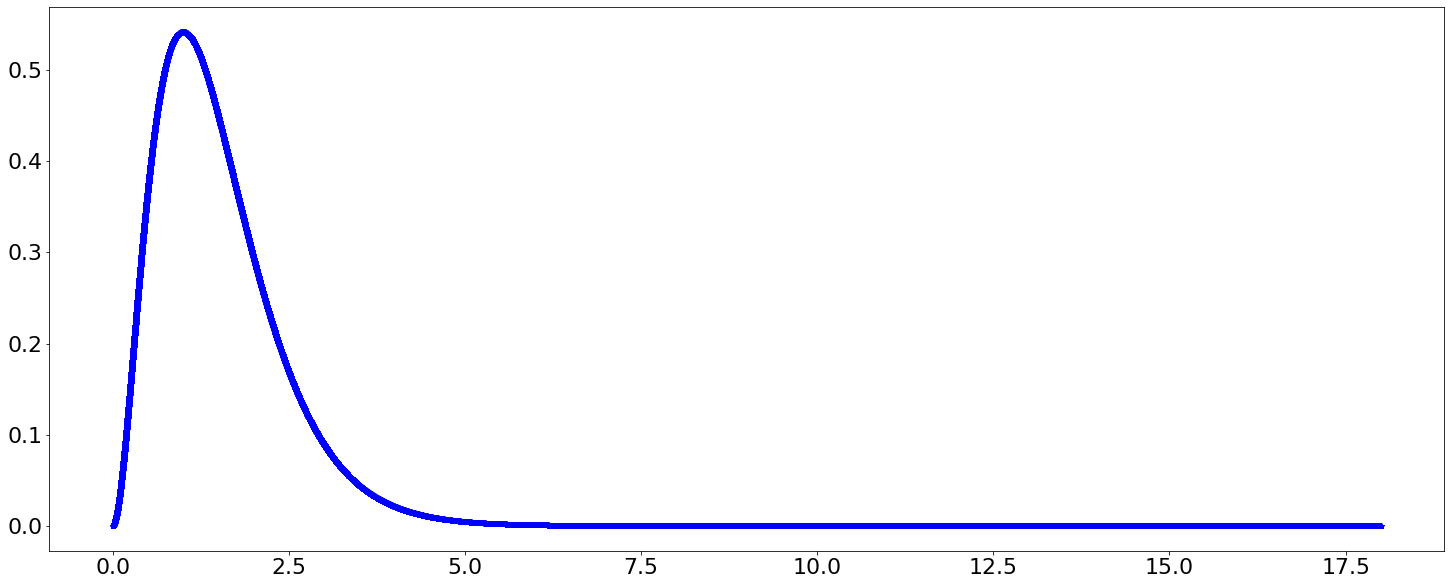

*******************************
E -0.1249417314587618
l 0


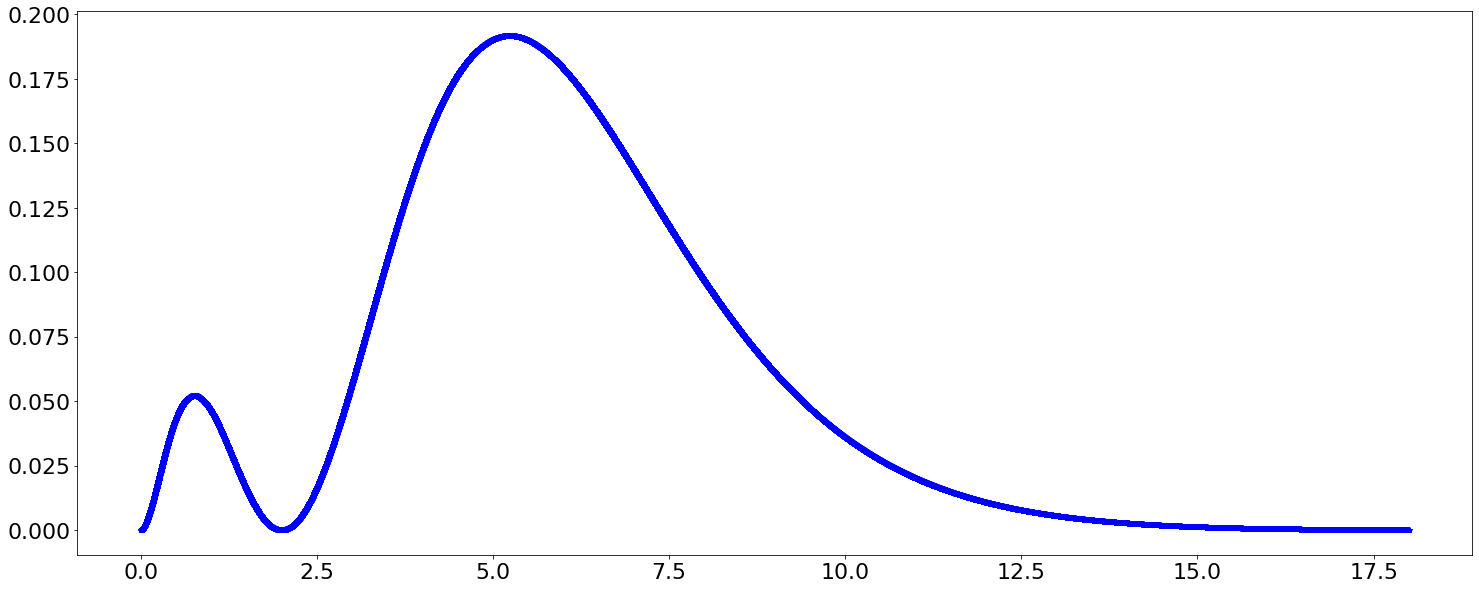

*******************************
E -0.0446702506622423
l 0


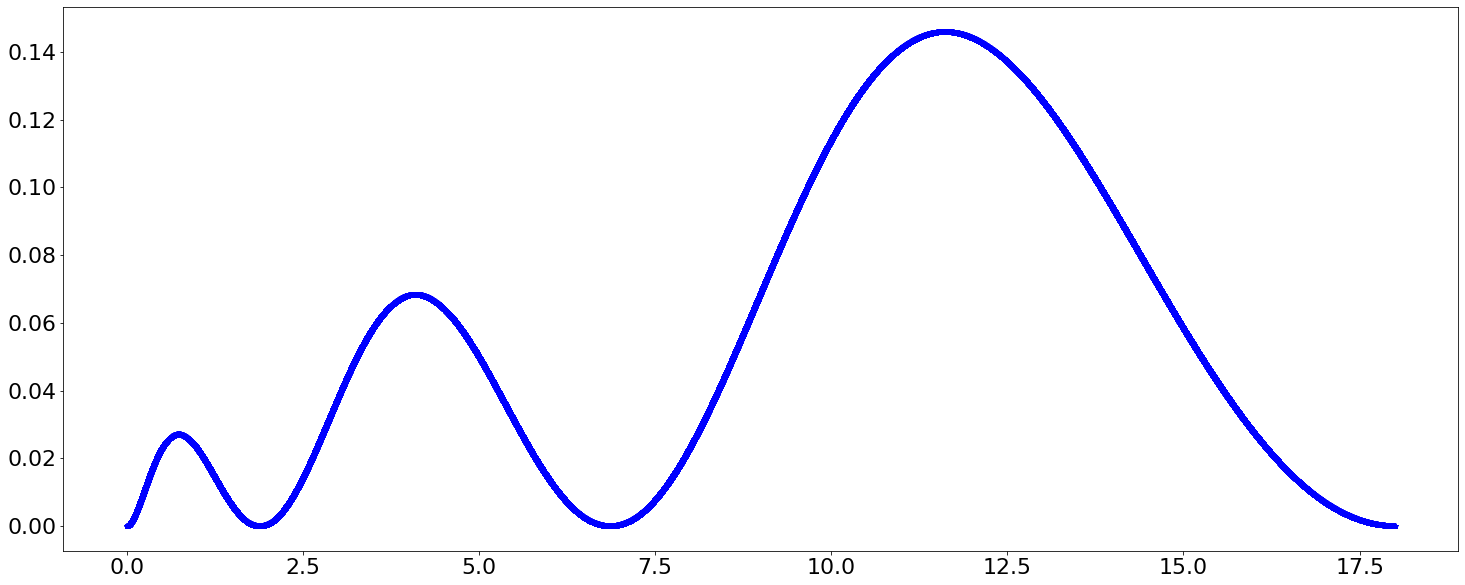

*******************************
E -0.49803202666357116
l 0


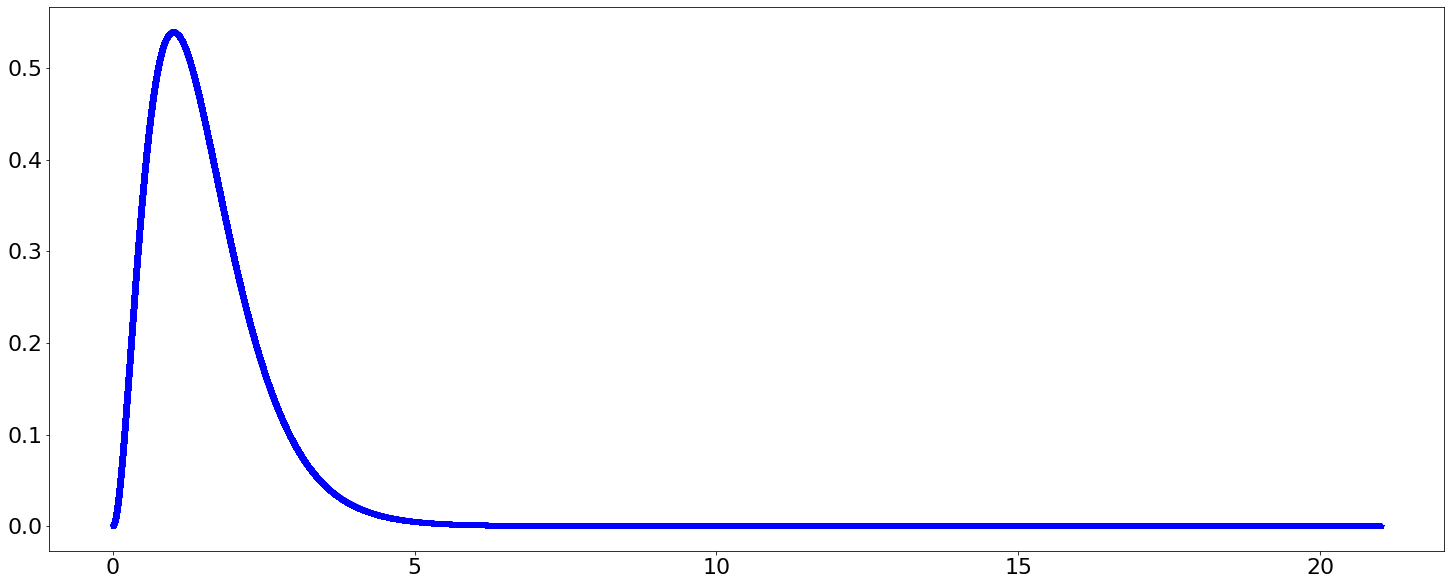

*******************************
E -0.12474760677794547
l 0


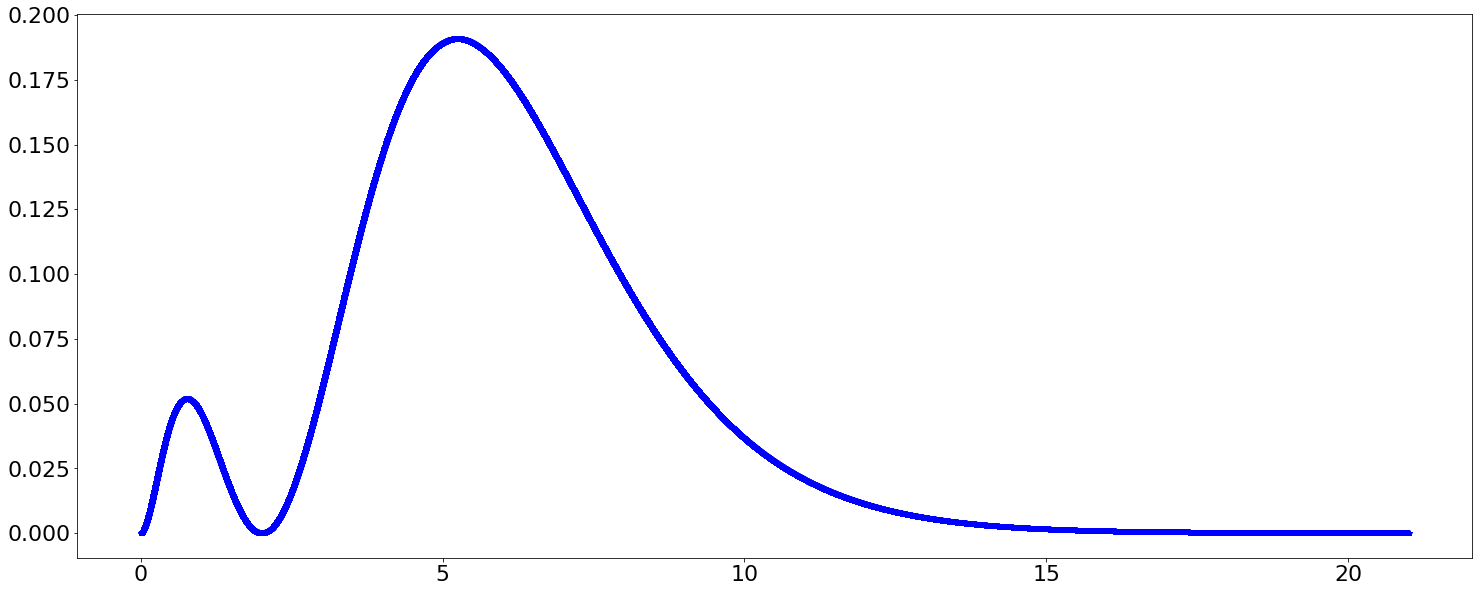

*******************************
E -0.05144874375985903
l 0


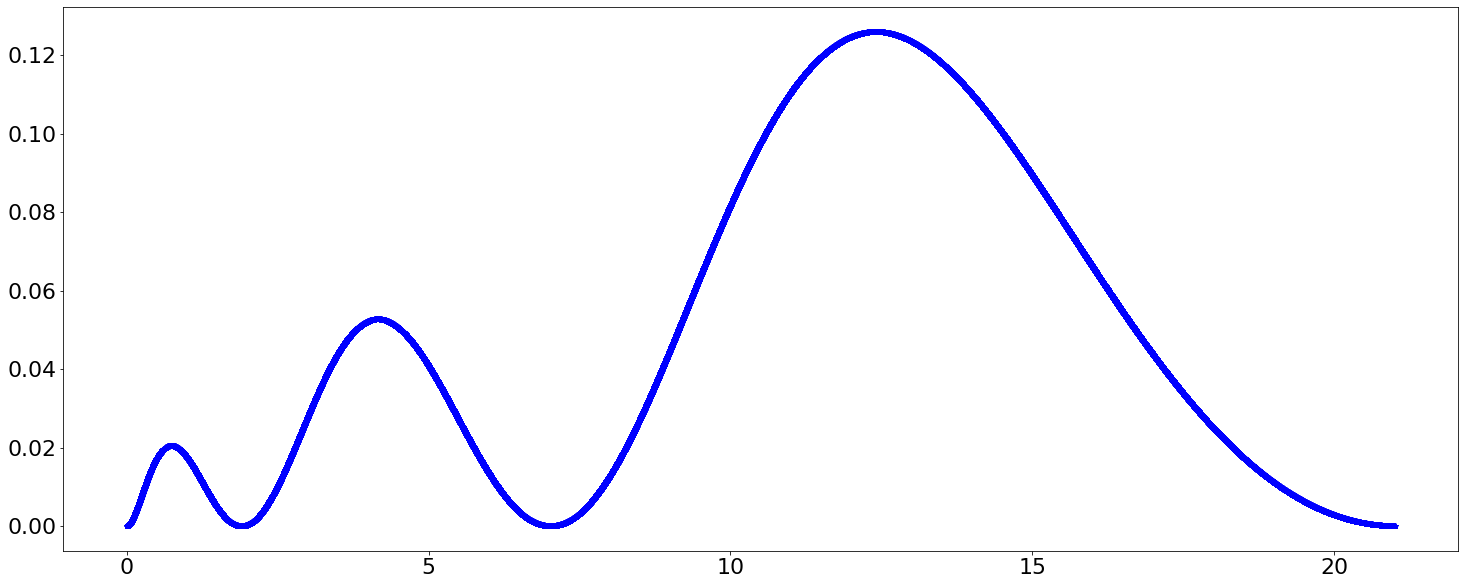

*******************************
E -0.12497490047009416
l 1


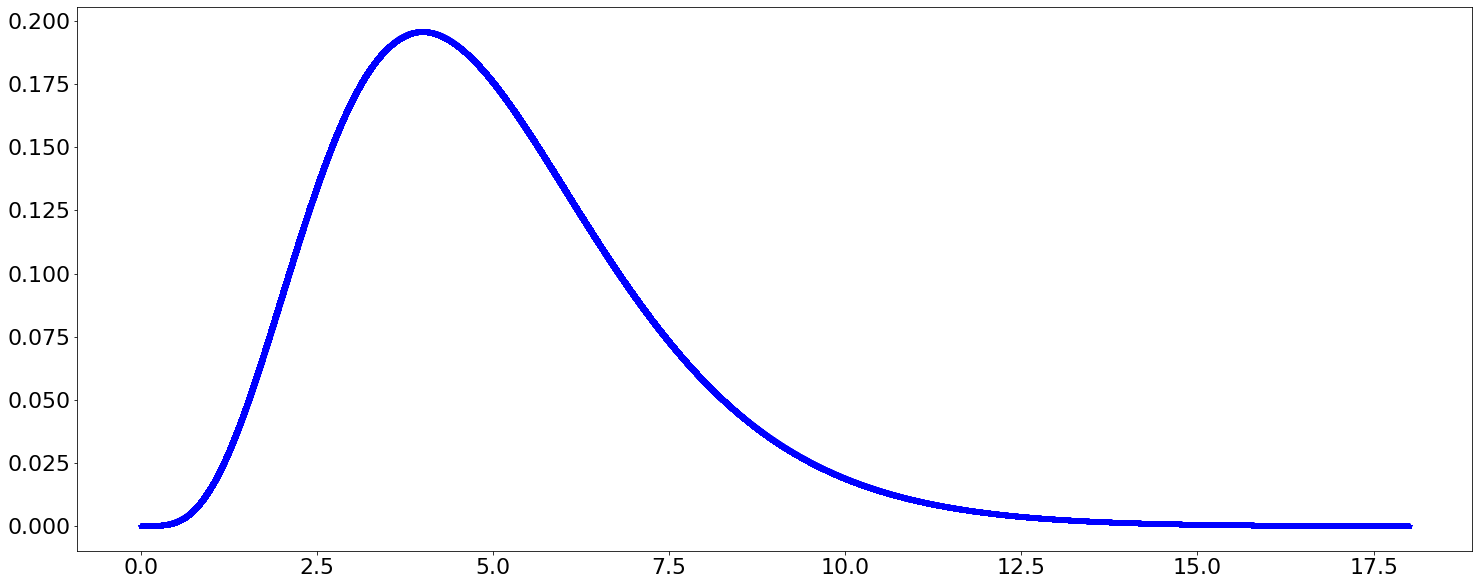

*******************************
E -0.04785204978396845
l 1


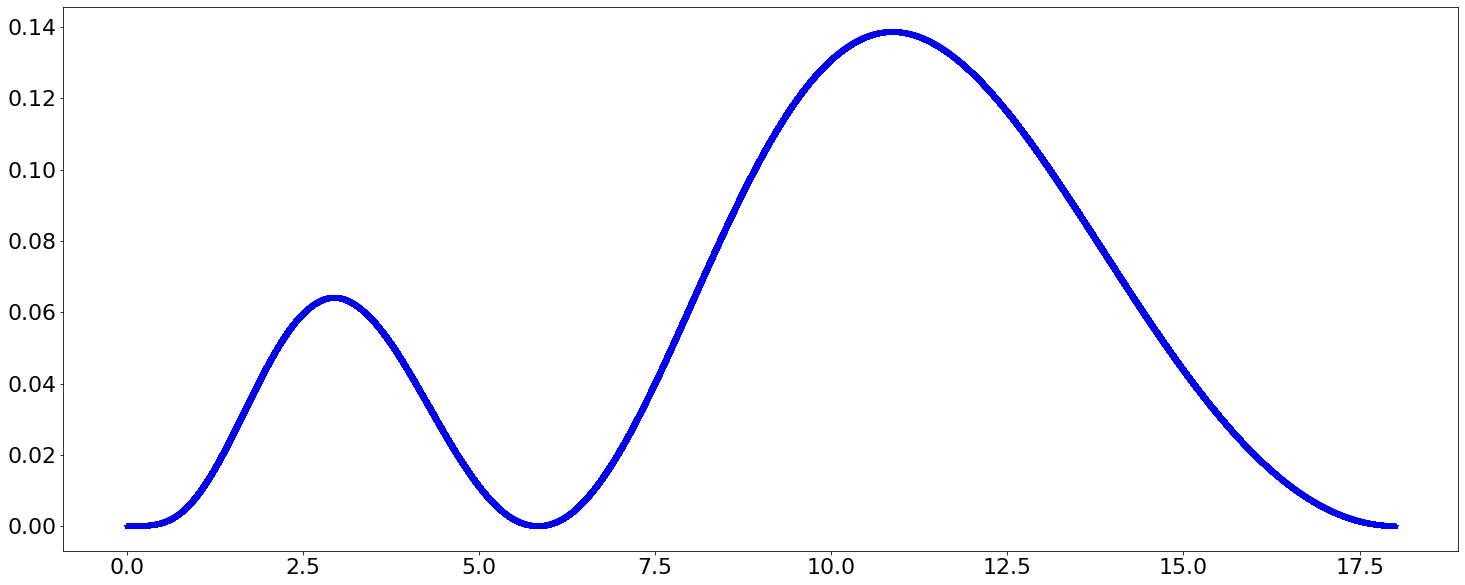

*******************************
E -0.1249975713202503
l 1


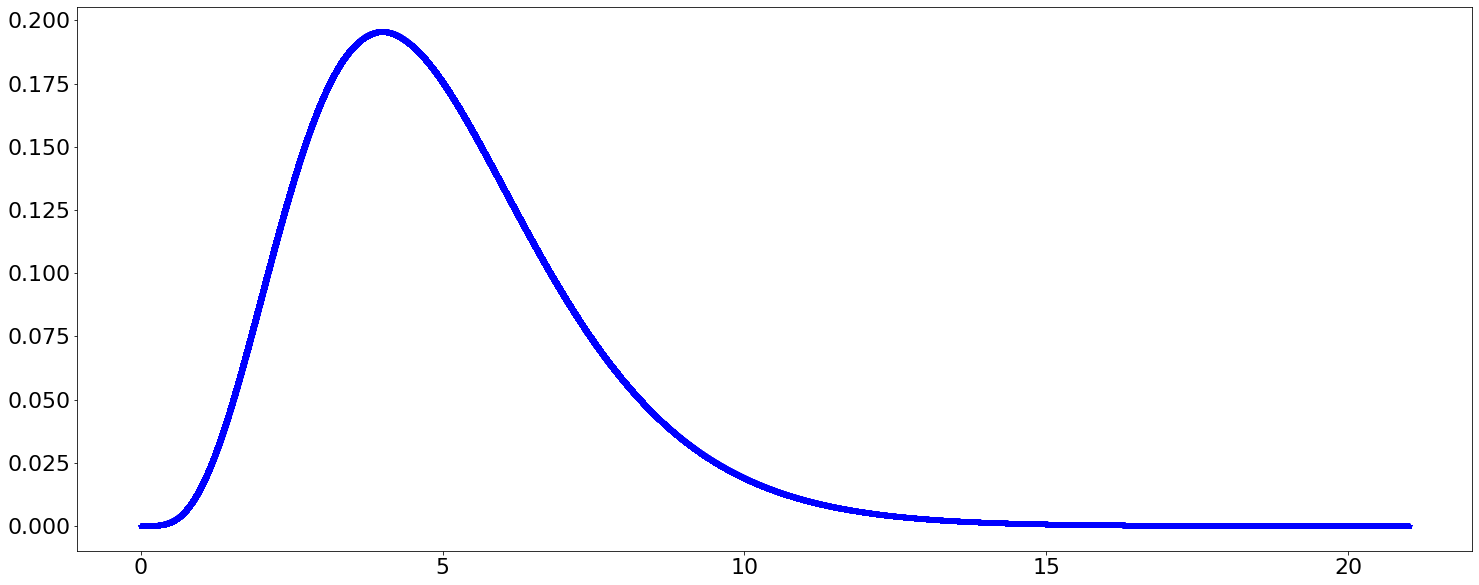

*******************************
E -0.05277287328242081
l 1


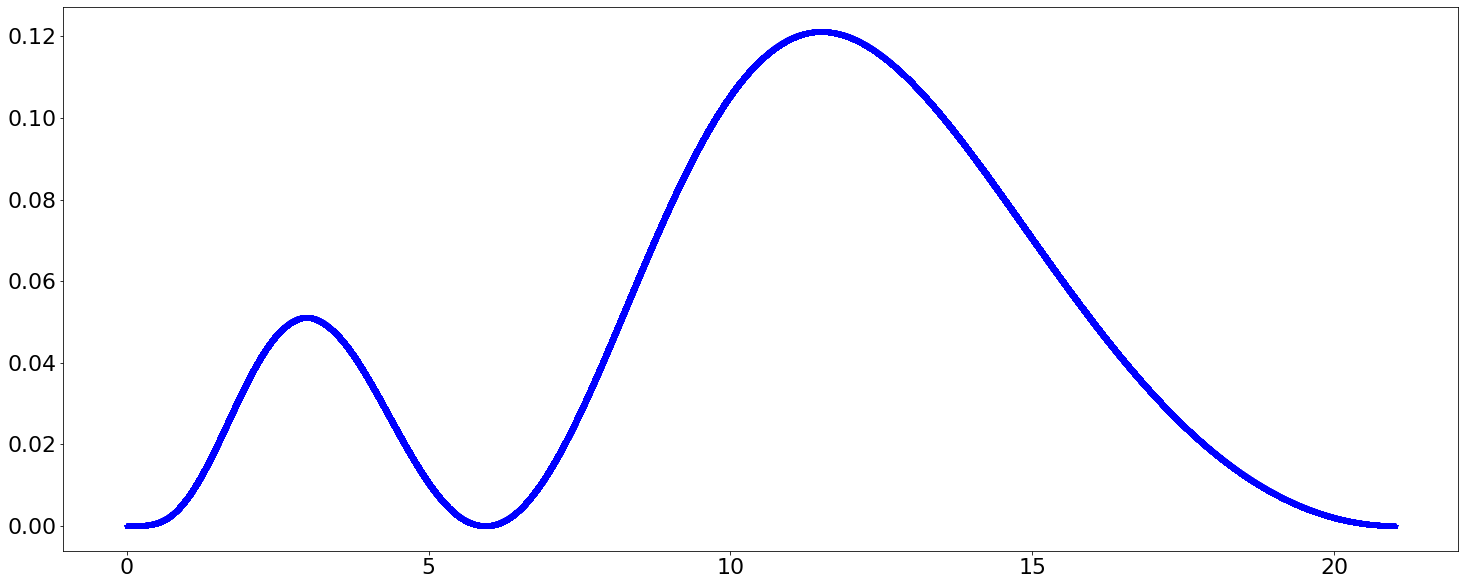

*******************************


In [17]:
for i, wf_objc in enumerate(potential_eigen_func):
    if wf_objc.E != None:
        #path=os.path.join(save_dir,f'Z_{wf_objc.Z}_E_{str(wf_objc.E)[:7]}_R_{str(wf_objc.r_N)[:3]}_l_{wf_objc.l}.json')
 
        #wf_objc.save_as_json(path)
        print('E',  wf_objc.E)
        print('l',  wf_objc.l)
        plt.plot(wf_objc.r_grid,wf_objc.U**2,'b*')
        plt.show()
        print('*******************************')

In [14]:
#select the best wf for a given eigenvalue
energy_reference={l:[] for l in l_arra} 
energy_groups={l:[] for l in l_arra} 
for i, i_wf_objc in enumerate(potential_eigen_func):
    if i_wf_objc.E != None:
        if len(energy_reference[i_wf_objc.l]) == 0:
            energy_reference[i_wf_objc.l].append(i_wf_objc.E)
            temp_group=[i]
            energy_groups[i_wf_objc.l].append(temp_group)
        else:
            reff_diff= np.abs(np.array(energy_reference[i_wf_objc.l]) - i_wf_objc.E) < 1.5e-2
            if True in reff_diff:
                for j, elem in enumerate(reff_diff):
                    if elem:
                        energy_groups[i_wf_objc.l][j].append(i)
            else:
                energy_reference[i_wf_objc.l].append(i_wf_objc.E)
                temp_group=[i]
                energy_groups[i_wf_objc.l].append(temp_group)

In [16]:
#elimitage groups of one element
energy_groups_temp=[]
for l,l_energy_group in energy_groups.items():
    for group in l_energy_group:
        if len(group) > 1:
            energy_groups_temp.append(group)
energy_groups= energy_groups_temp

In [17]:
for group in energy_groups:
    for elem in group:
        print('E ', potential_eigen_func[elem].E)
        print('U0', potential_eigen_func[elem].U[0])
    print('++++++++++++++++++++++++++++++')

E  -0.4999996669957253
U0 3.14832723277096e-18
E  -0.49803202666357116
U0 1.0250432085256528e-13
++++++++++++++++++++++++++++++
E  -0.1249417314587618
U0 2.292303798469641e-18
E  -0.12474760677794547
U0 -1.8008309409398405e-14
++++++++++++++++++++++++++++++
E  -0.0446702506622423
U0 3.470868064480358e-19
E  -0.05144874375985903
U0 -1.3814031236867382e-15
++++++++++++++++++++++++++++++
E  -0.12497490047009416
U0 1.3226782557035162e-27
E  -0.1249975713202503
U0 -5.89504077051197e-11
++++++++++++++++++++++++++++++
E  -0.04785204978396845
U0 -3.9247094963957225e-27
E  -0.05277287328242081
U0 4.529765577365453e-09
++++++++++++++++++++++++++++++


In [18]:
#final selection
eigen_funct=[]
for group in energy_groups:
    temp=[sum(potential_eigen_func[elem].U[-100:]) for elem in group]
    eigen_funct.append(potential_eigen_func[group[np.argsort(temp)[0]]])

E -0.49803202666357116
l 0


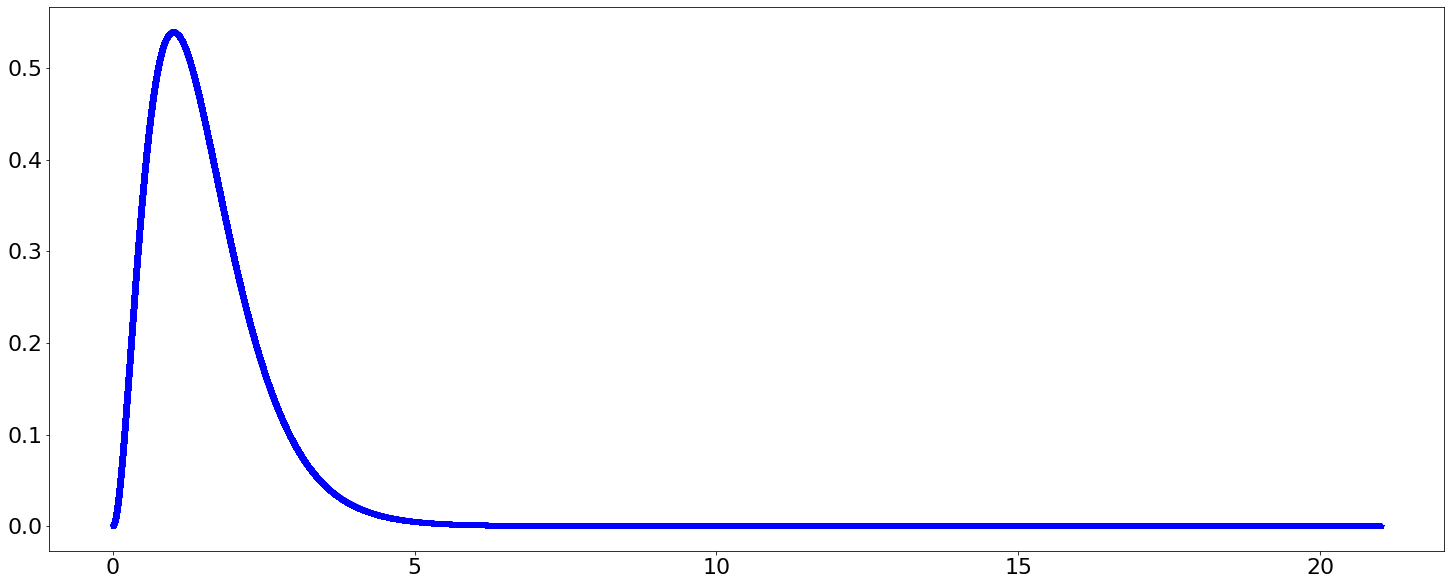

*******************************
E -0.12474760677794547
l 0


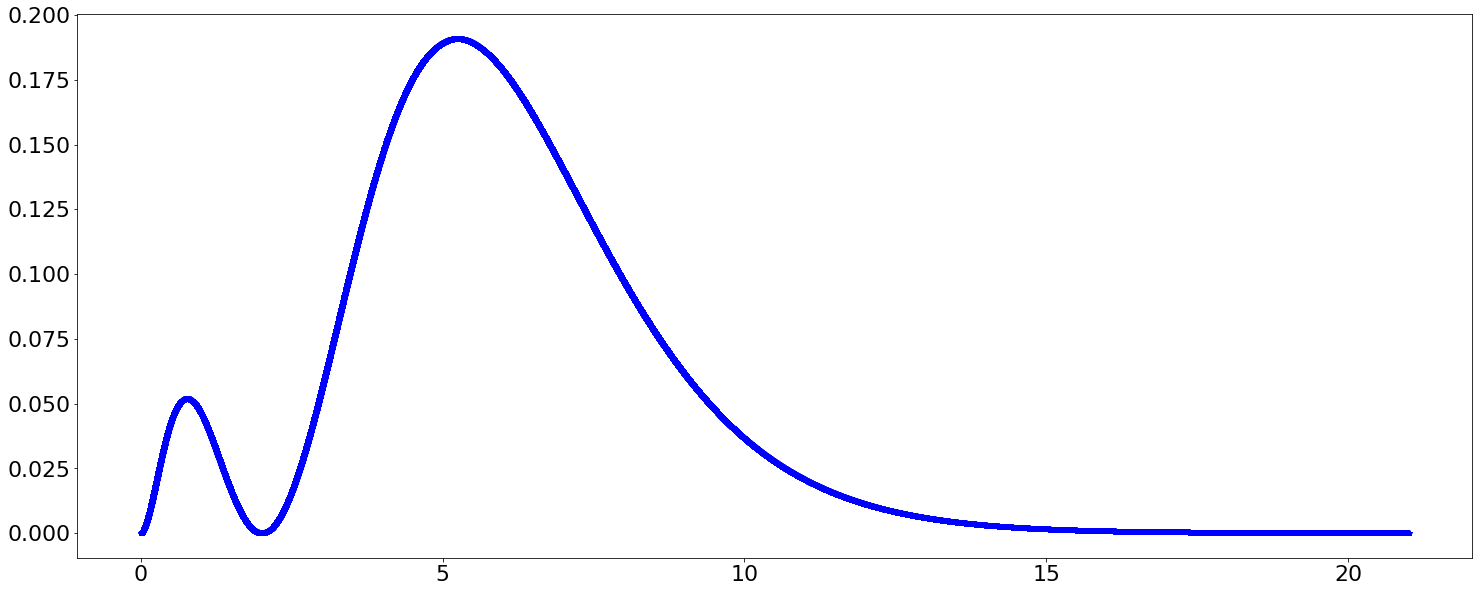

*******************************
E -0.05144874375985903
l 0


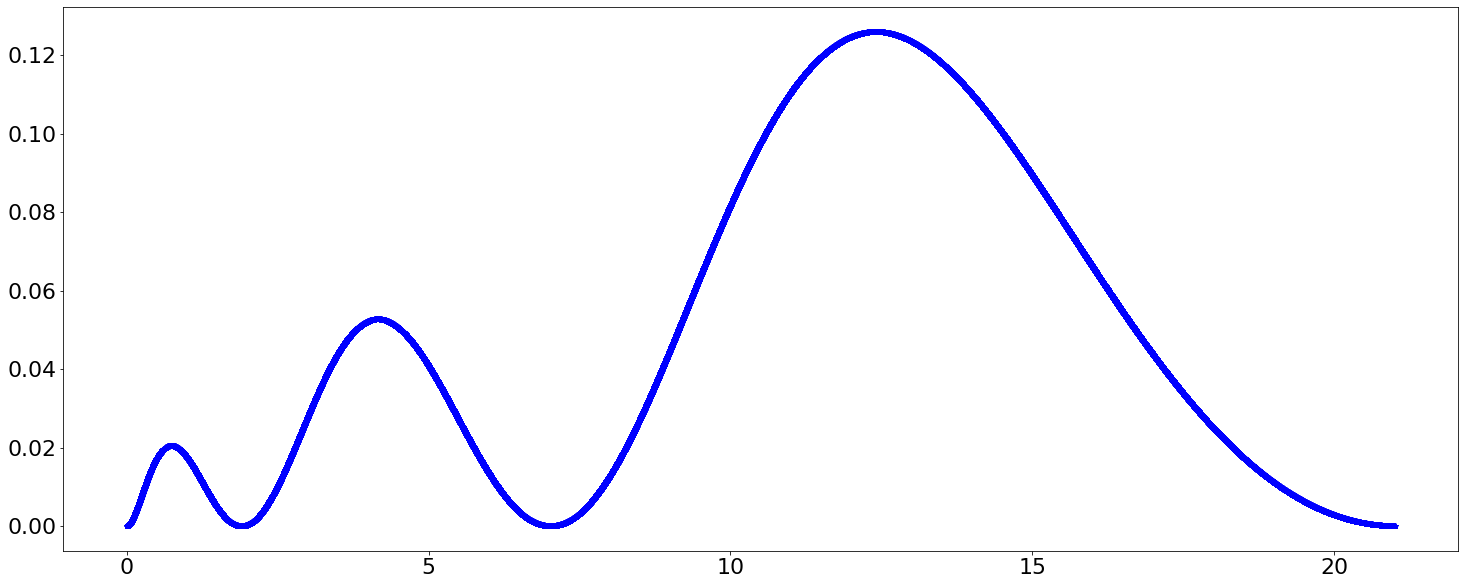

*******************************
E -0.1249975713202503
l 1


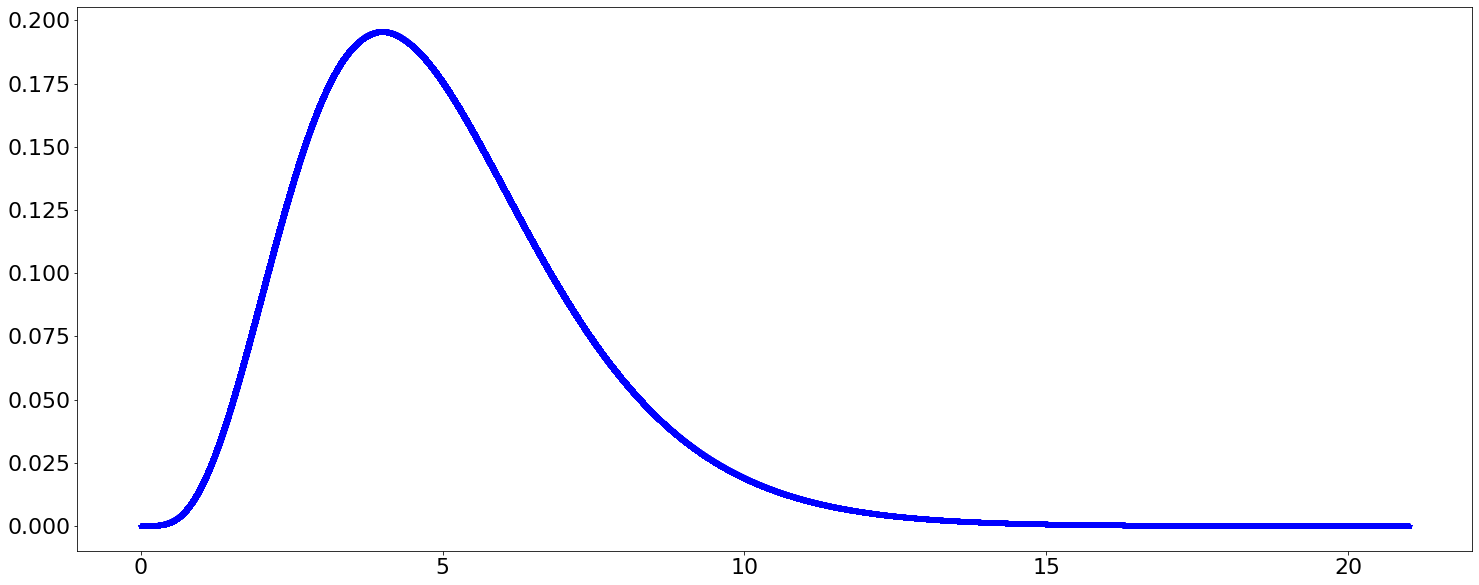

*******************************
E -0.05277287328242081
l 1


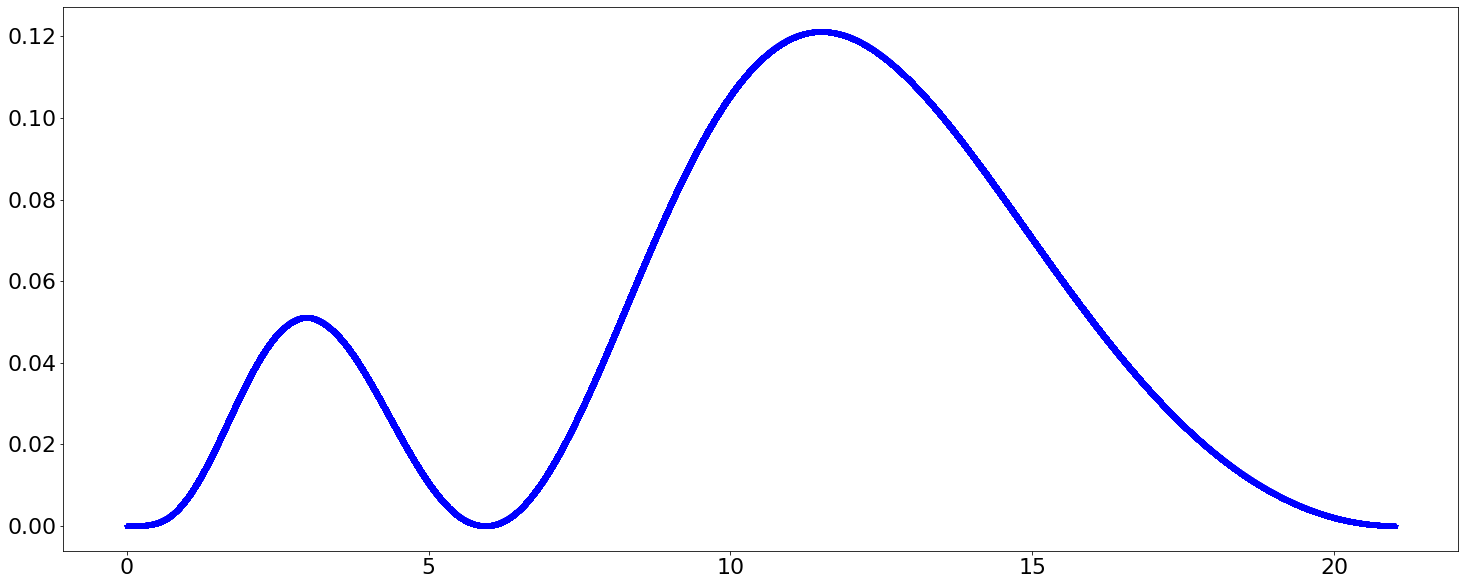

*******************************


In [19]:
save_dir='wave_function_jsons'
for i, wf_objc in enumerate(eigen_funct):
    if wf_objc.E != None:
        path=os.path.join(save_dir,f'Z_{wf_objc.Z}_E_{str(wf_objc.E)[:7]}_R_{str(wf_objc.r_N)[:3]}_l_{wf_objc.l}.json')
 
        wf_objc.save_as_json(path)
        print('E',  wf_objc.E)
        print('l',  wf_objc.l)
        plt.plot(wf_objc.r_grid,wf_objc.U**2,'b*')
        plt.show()
        print('*******************************')

In [17]:
save_dir='wave_function_jsons'
bf_array=[]
for file in os.listdir(save_dir):
    temp_bf= Radial_Eigenfunction(0.0,0.0,0.0, 0.0, 0.0, 0.0, 0.0,0.0)
    path=os.path.join(save_dir,file)
    temp_bf.restore_from_json(path)
    bf_array.append(temp_bf)

E -0.12450204071783055
l 0


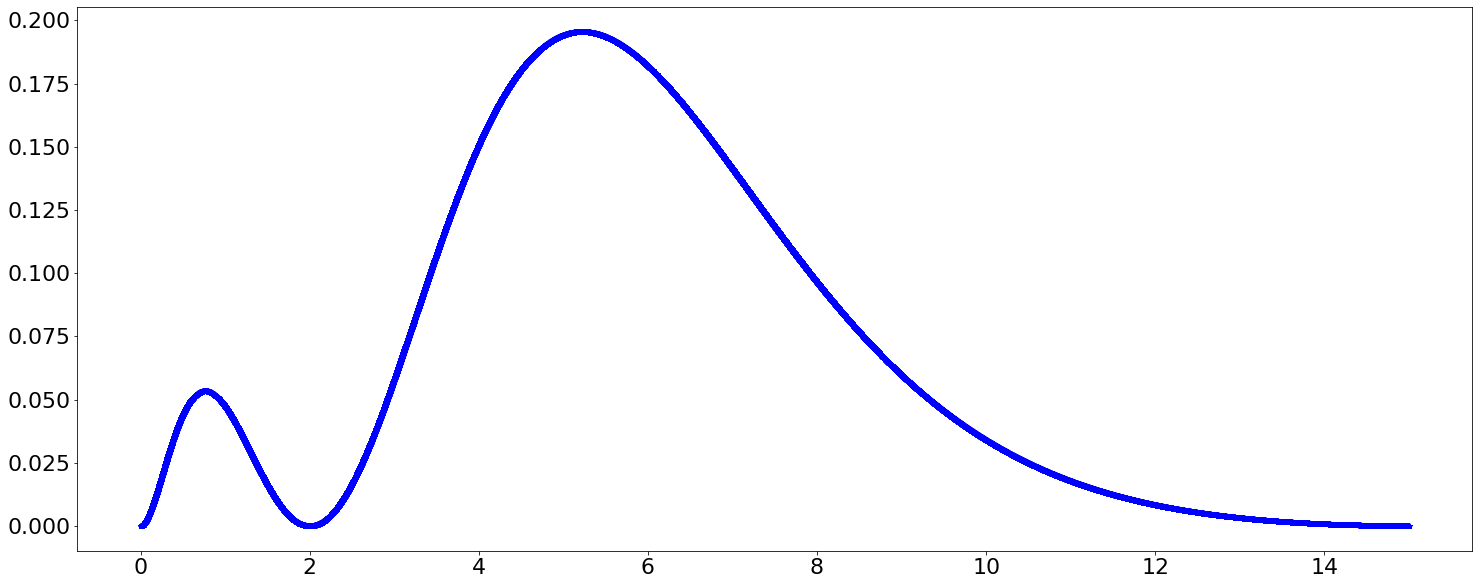

*******************************
E -0.02695724482301105
l 0


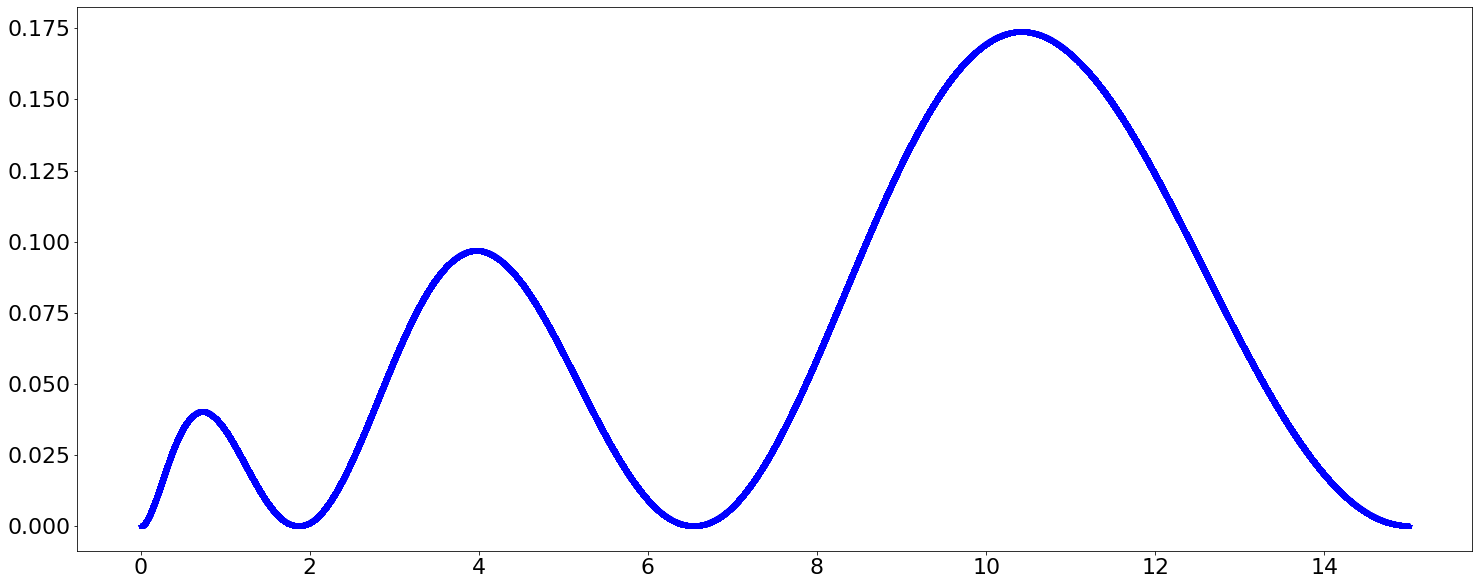

*******************************
E -0.49999966691600584
l 0


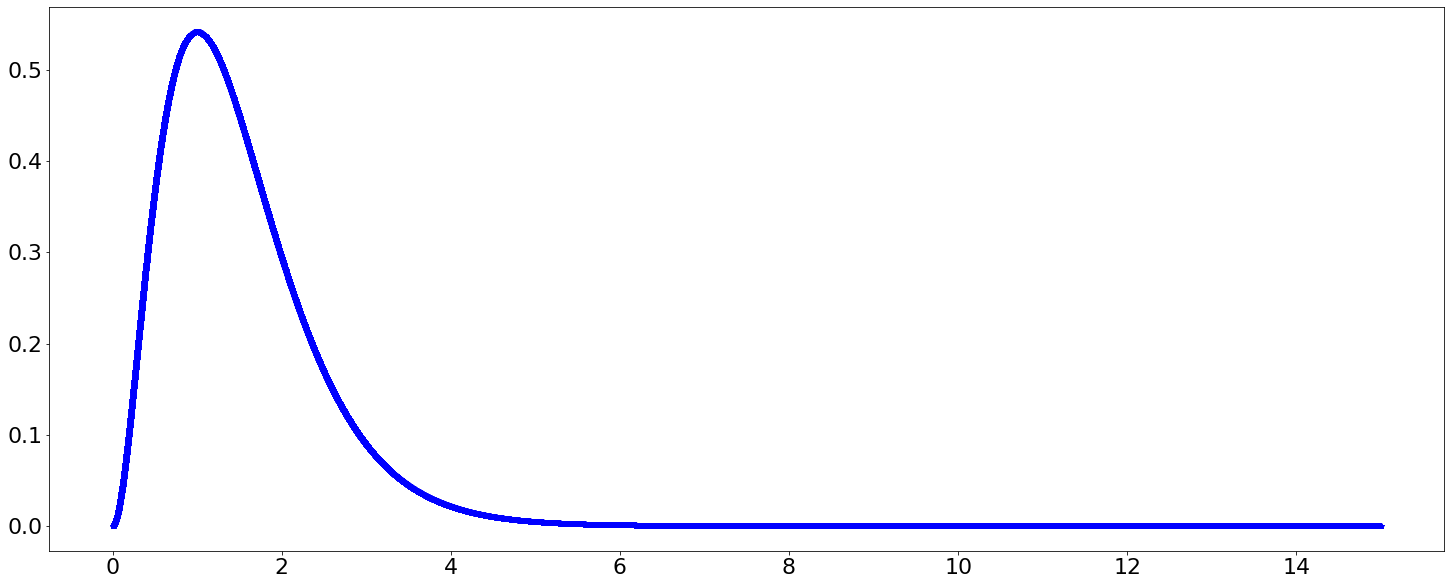

*******************************


In [18]:
for i, wf_objc in enumerate(bf_array):
    if wf_objc.E != None:
        print('E',  wf_objc.E)
        print('l',  wf_objc.l)
        plt.plot(wf_objc.r_grid,wf_objc.U**2,'b*')
        plt.show()
        print('*******************************')